In [24]:
import os
import rootutils
rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)

PosixPath('/Users/tomeknocon/MIM/Master_Thesis/IMMUVIS-PIGVAE')

In [25]:
from torchvision import transforms
from torchvision import datasets
import torch
from src.data.components.graphs_datamodules import  SplitPatches, CellDataset, GraphDataModule
from src.data.mnist_datamodule import MNISTDataModule

In [3]:
from torchvision.datasets import MNIST
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split

transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize((0.1307,), (0.3081,)),
            transforms.Resize((24, 24)),
            transforms.Lambda(lambda x: x.unsqueeze(0)),
            SplitPatches(4)
        ])

trainset = MNIST(
               '../data', train=True, transform=transform
            )
testset = MNIST(
               '../data', train=False, transform=transform
            )
dataset = ConcatDataset(datasets=[trainset, testset])

In [4]:
data_train, data_val, data_test = random_split(
                dataset=dataset,
                lengths=[100, 10, 69890],
                generator=torch.Generator().manual_seed(42),
            )

In [5]:
import networkx as nx

class GridGraphDataset(Dataset):
    def __init__(self,
                 dataset,
                 grid_size: int, 
                 channels, 
        ):
        self.grid_size = grid_size
        self.dataset = dataset
        self.channels = channels
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        g = nx.grid_graph((self.grid_size, self.grid_size))
        img = self.dataset[idx][0].to(torch.float32)
        target =self.dataset[idx][1]
        return (g, img, target)

In [7]:
d = GridGraphDataset(data_train, 6, [0])

In [8]:
m = MNISTDataModule('../data', [100, 10, 69890], 32, 1)

In [9]:
m.setup()
t = m.train_dataloader()

In [10]:
batches = [el for el in t]

In [49]:
from dataclasses import dataclass, asdict
import os

DEFAULT_SAVE_DIR = os.path.join(os.getcwd())

@dataclass
class Params:
    id: int = 0
    num_epochs: int = 10
    num_eval_samples: int = 8192
    eval_freq: int = 1000
    save_dir: str = DEFAULT_SAVE_DIR
    precision: int = 32
    progress_bar: bool = True
    test: bool = False
    resume_ckpt: str = ""
    batch_size: int = 32
    lr: float = 0.0005
    kld_loss_scale: float = 0.001
    perm_loss_scale: float = 0.5
    property_loss_scale: float = 0.1
    vae: bool = True
    num_node_features: int = 16
    num_edge_features: int = 0
    emb_dim: int = 16
    grid_size: int = 6
    graph_encoder_hidden_dim: int = 32
    graph_encoder_k_dim: int = 8
    graph_encoder_v_dim: int = 8
    graph_encoder_num_heads: int = 2
    graph_encoder_ppf_hidden_dim: int = 128
    graph_encoder_num_layers: int = 4
    graph_decoder_hidden_dim: int = 32
    graph_decoder_k_dim: int = 8
    graph_decoder_v_dim: int = 8
    graph_decoder_num_heads: int = 2
    graph_decoder_ppf_hidden_dim: int = 128
    graph_decoder_pos_emb_dim: int = 8
    graph_decoder_num_layers: int = 4
    property_predictor_hidden_dim: int = 32
    num_properties: int = 1
    num_workers: int = 1
    shuffle: int = 1
    graph_family: str = "grid"
    n_min: int = 12
    n_max: int = 20
    p_min: float = 0.4
    p_max: float = 0.6
    m_min: int = 1
    m_max: int = 5

# Example usage
hparams = Params()

# Convert to dictionary
# params_dict = asdict(hparams)

# print(params_dict)


In [26]:
from models.components.model import Critic
from models.pigvae_auto_module import PLGraphAE

ModuleNotFoundError: No module named 'models'

In [42]:
import sys
import os
import torch

# Add root directory to sys.path
sys.path.append(os.path.abspath('../src'))

In [54]:
import hydra
from omegaconf import OmegaConf
from hydra.utils import instantiate


In [66]:
from omegaconf import OmegaConf

cfg = OmegaConf.load("../configs/model/model.yaml")
model = hydra.utils.instantiate(cfg)


/Users/tomeknocon/MIM/Master_Thesis/IMMUVIS-PIGVAE/src/models/components/spectral_embeddings.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  sorted_eigenvecs = torch.tensor(
/Users/tomeknocon/opt/anaconda3/envs/pigvae/lib/python3.8/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/Users/tomeknocon/opt/anaconda3/envs/pigvae/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'critic' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['critic'])`.
/Users/tomeknocon/opt/anaconda3/envs/pigvae/lib/python3.

In [68]:
model.load_state_dict(torch.load('../logs/train/runs/2025-02-21_00-38-31/checkpoints/last.ckpt')['state_dict'])
model.eval()

PLGraphAE(
  (graph_ae): GraphAE(
    (encoder): GraphEncoder(
      (posiotional_embedding): PositionalEncoding()
      (graph_transformer): Transformer(
        (blocks): ModuleList(
          (0-3): 4 x TransformerBlock(
            (attention_layer): SelfAttention(
              (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
              (input_projection): Linear(in_features=32, out_features=96, bias=False)
              (output_projection): Linear(in_features=32, out_features=32, bias=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (feed_forward_layer): Sequential(
              (ff_layernorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
              (pre_relu): Linear(in_features=32, out_features=128, bias=True)
              (relu): ReLU()
              (post_relu): Linear(in_features=128, out_features=32, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
        )
 

In [69]:
b = model(batches[-2], True)

In [70]:
def restore_tensor(a, bs, c, h, w, patch_size):
    # Step 1: Reshape a to match the patch grid layout
    a = a.view(bs, -1, c, patch_size, patch_size)
    # a -> (B, num_patches, C, patch_size, patch_size)
    
    # Step 2: Reshape back to (B, C, H, W) by folding the patches
    # Calculate the grid size (L) which is the number of patches in each row and column
    grid_size = int(a.size(1) ** 0.5)  # Assumes square grid (height = width for the patches)
    
    # Unfold back into the original image size
    a = a.view(bs, grid_size, grid_size, c, patch_size, patch_size)
    # a -> (B, grid_size, grid_size, C, patch_size, patch_size)
    
    # Step 3: Permute and reshape to get back to the image format (B, C, H, W)
    x_reconstructed = a.permute(0, 3, 1, 4, 2, 5).contiguous()
    # x_reconstructed -> (B, C, grid_size, patch_size, grid_size, patch_size)
    
    x_reconstructed = x_reconstructed.view(bs, c, h, w)
    # x_reconstructed -> (B, C, H, W)
    
    return x_reconstructed

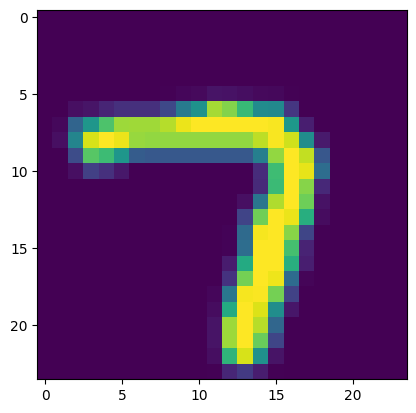

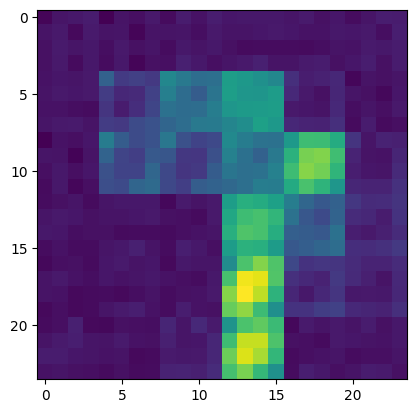

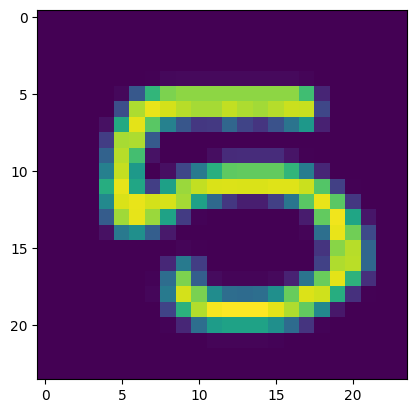

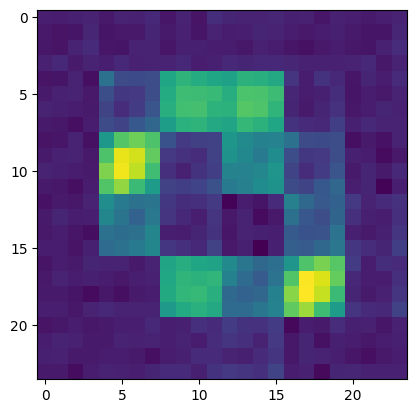

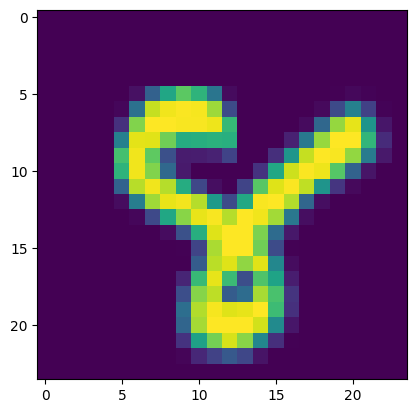

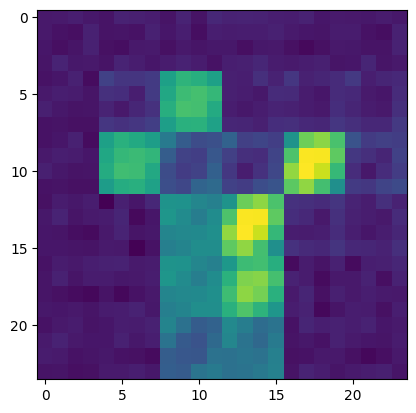

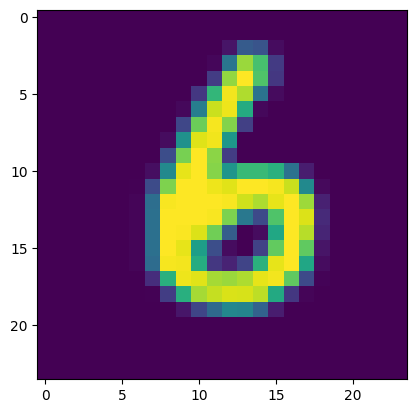

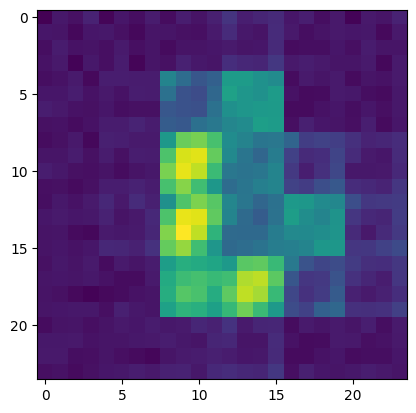

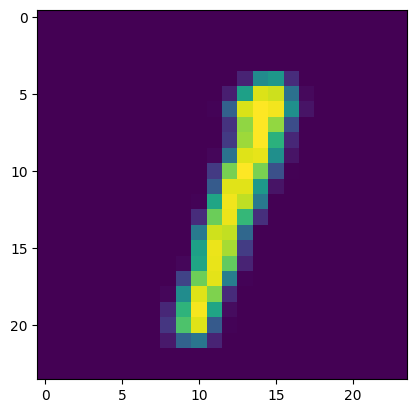

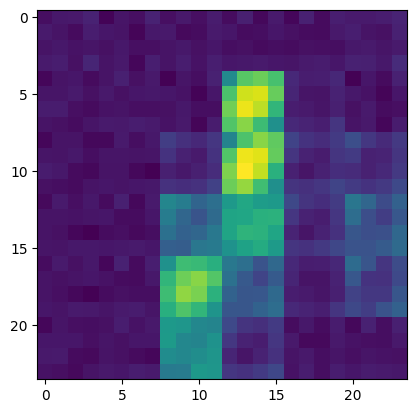

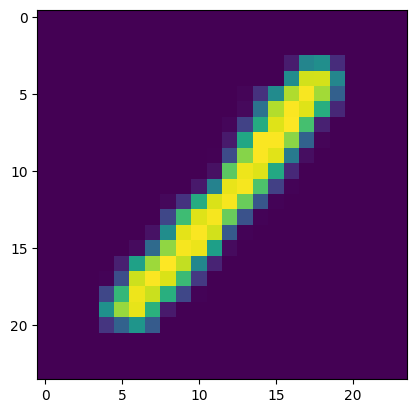

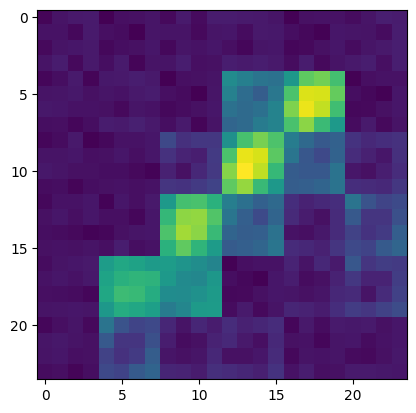

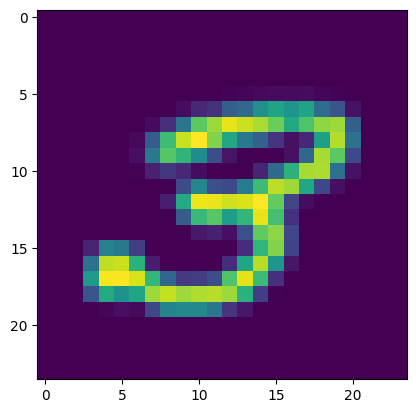

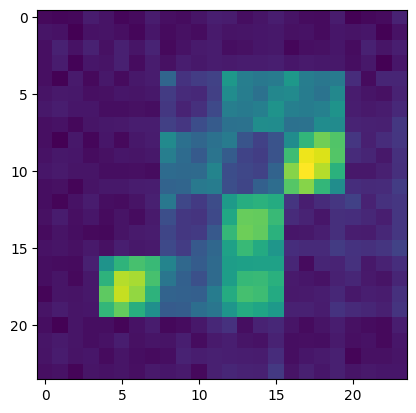

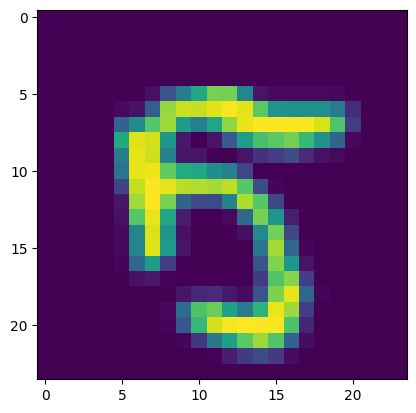

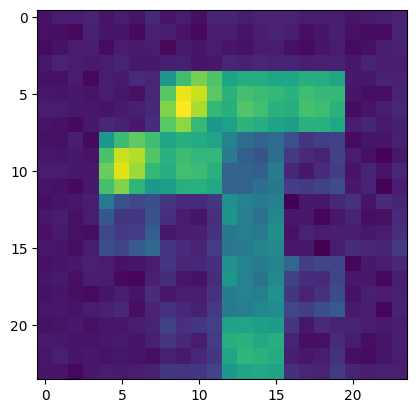

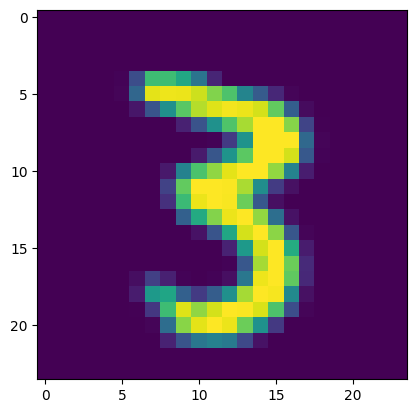

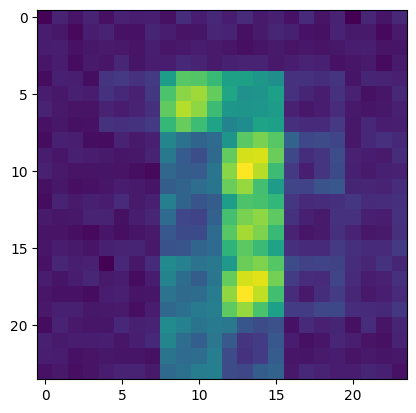

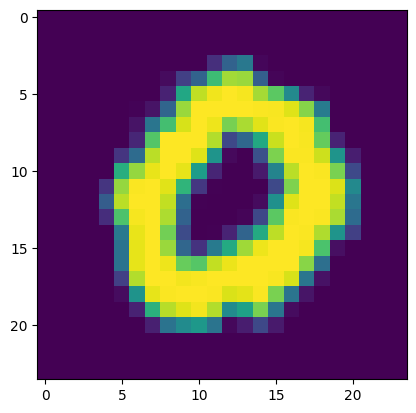

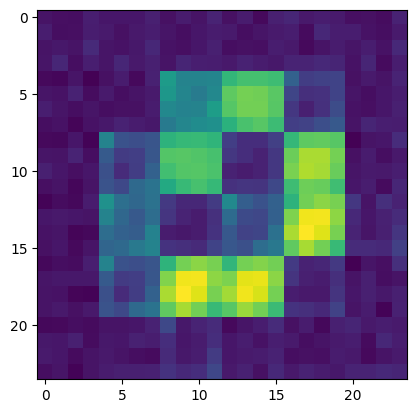

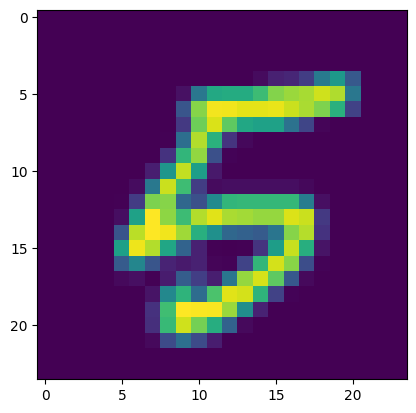

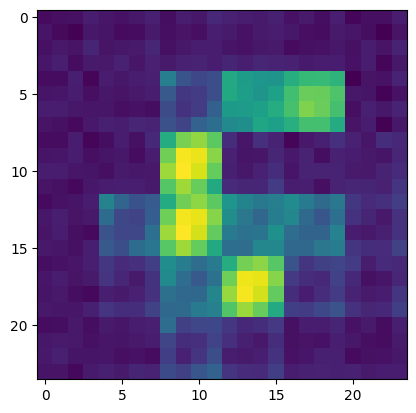

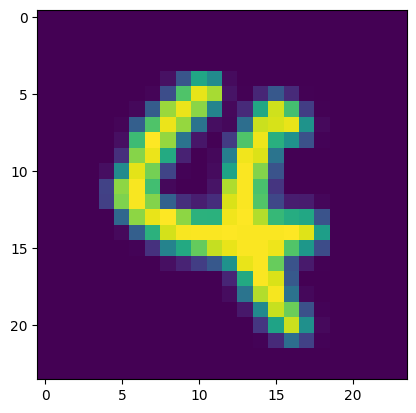

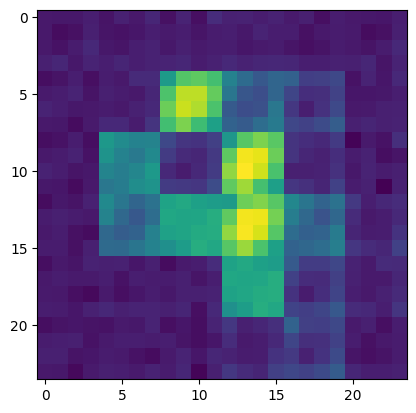

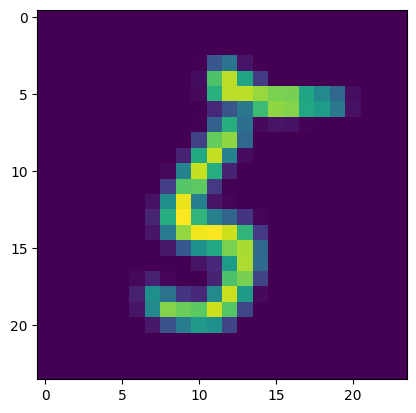

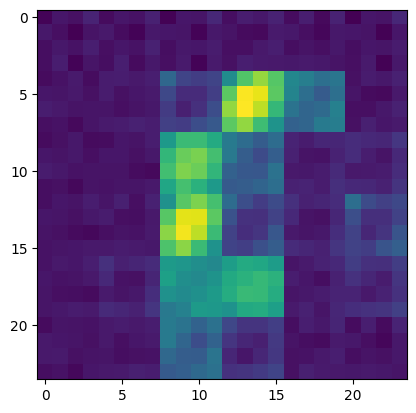

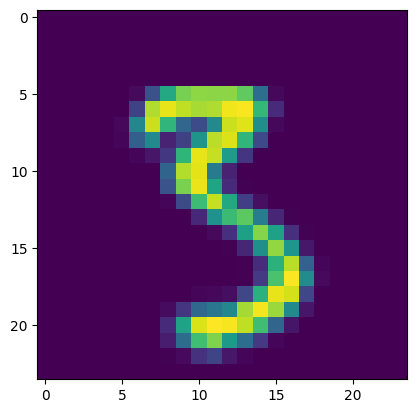

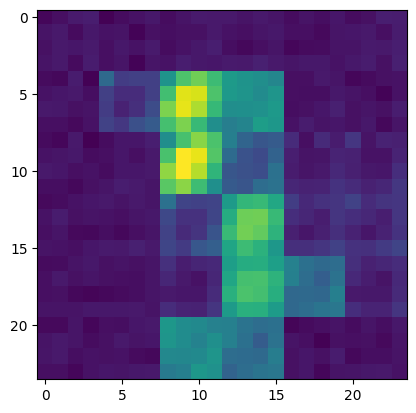

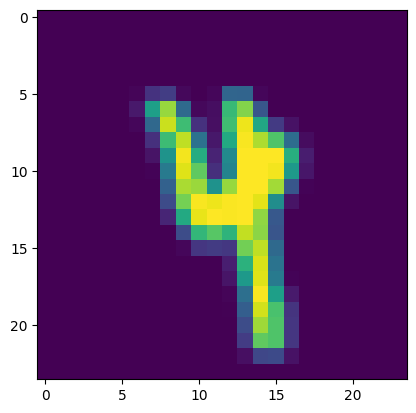

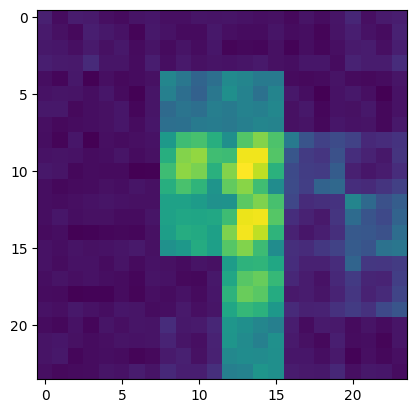

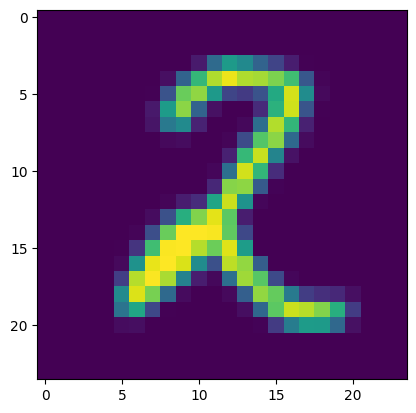

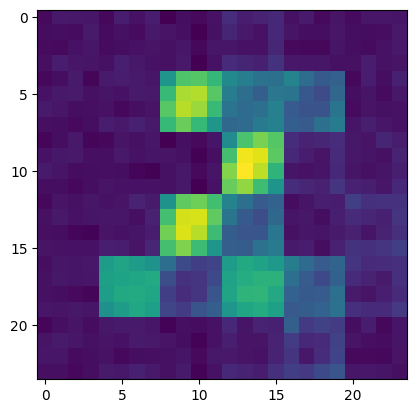

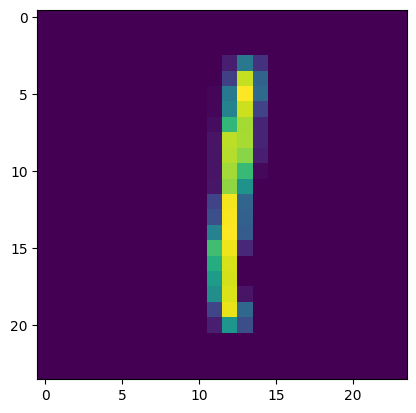

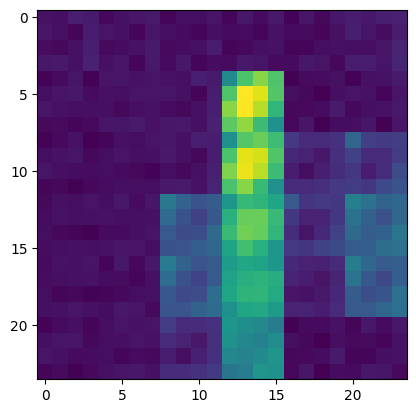

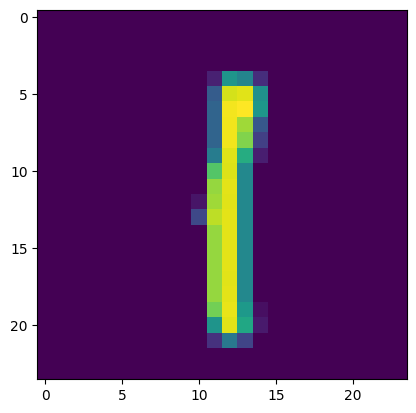

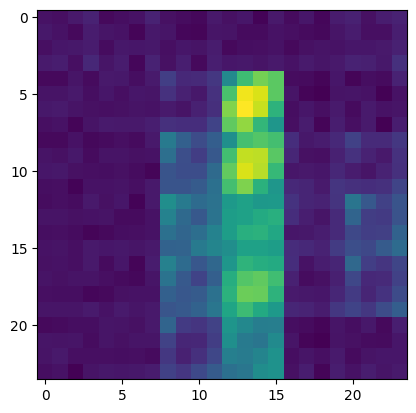

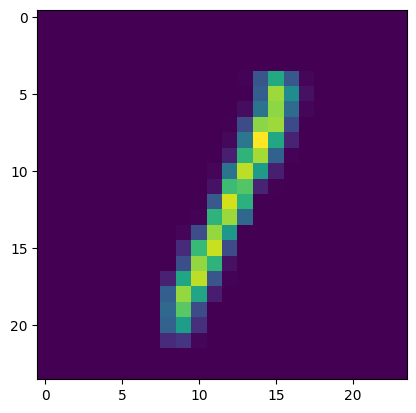

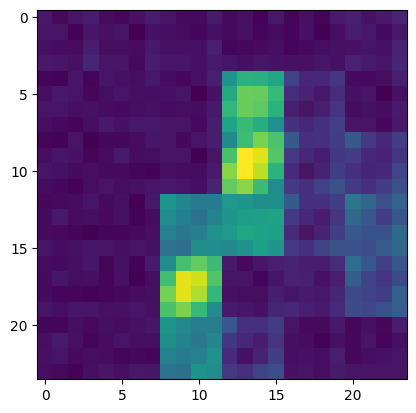

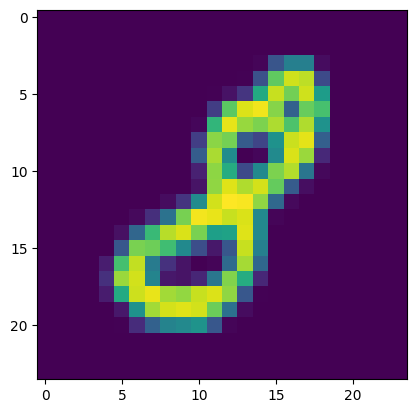

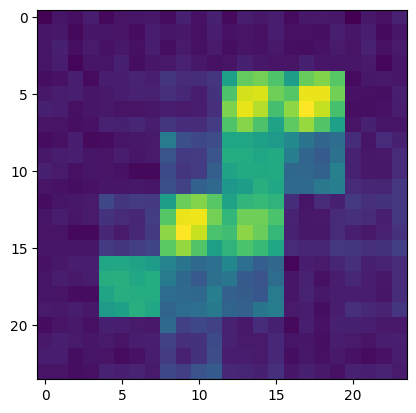

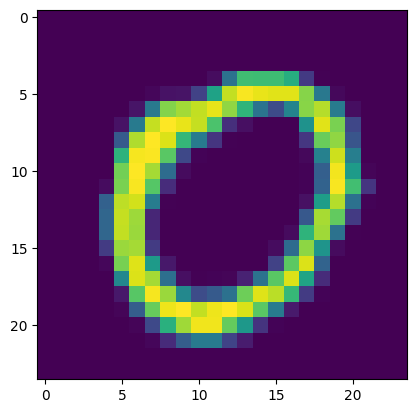

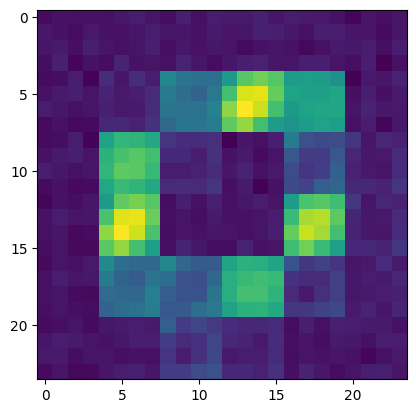

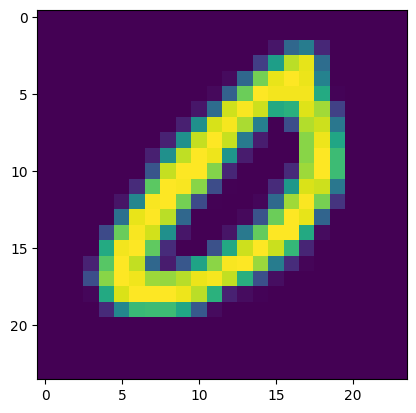

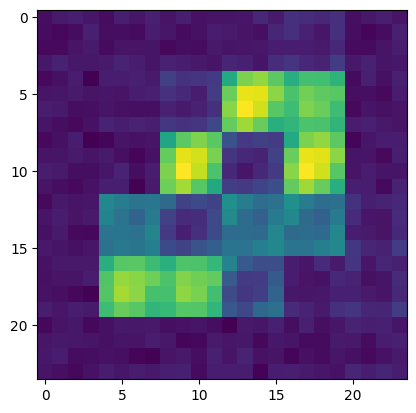

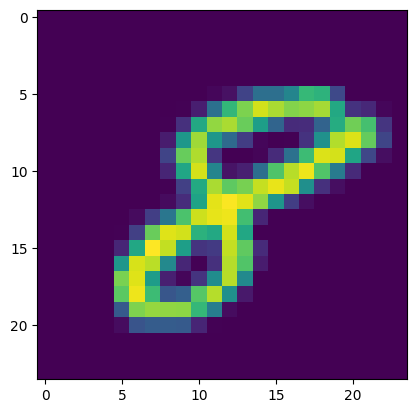

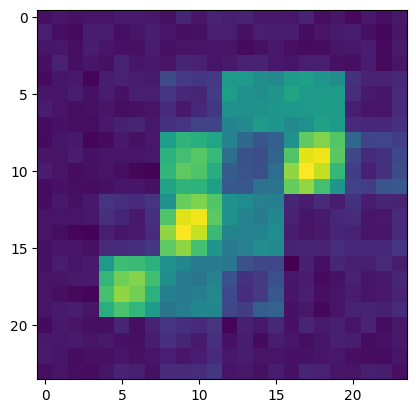

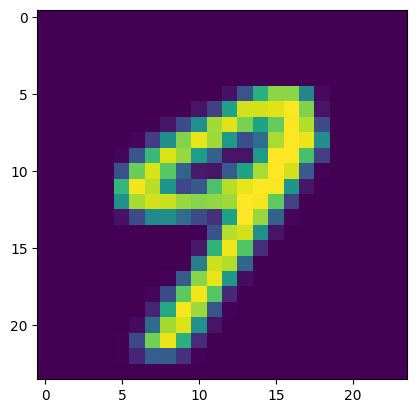

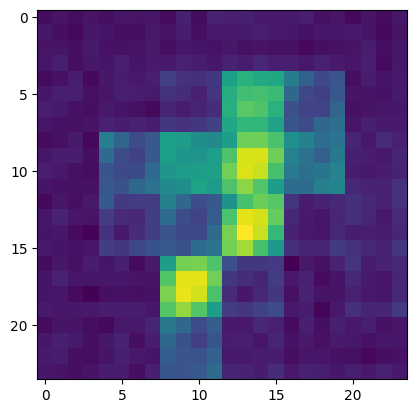

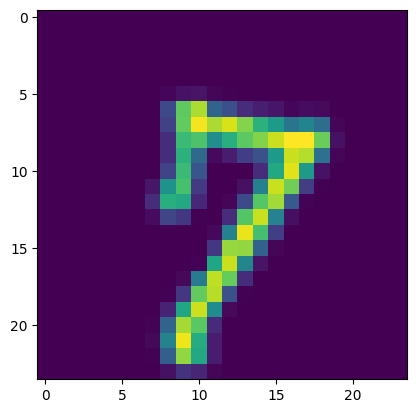

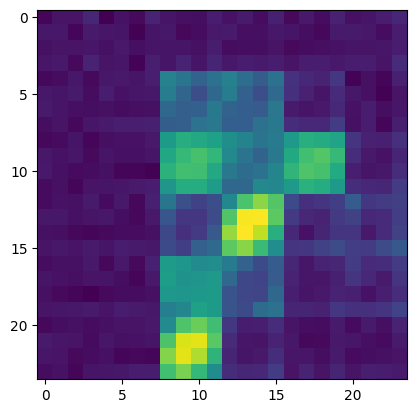

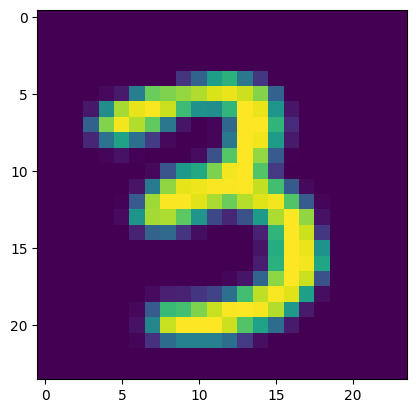

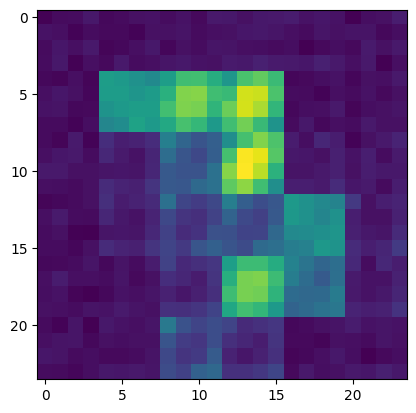

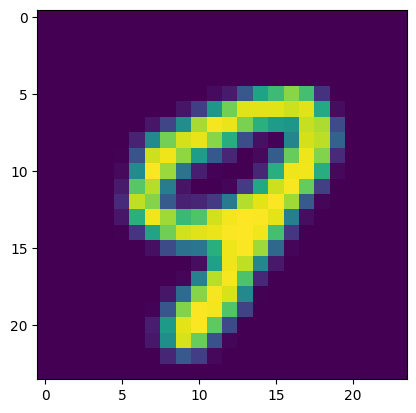

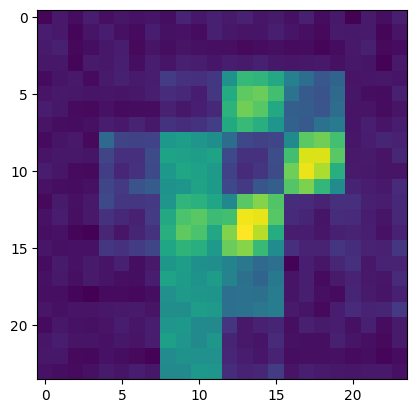

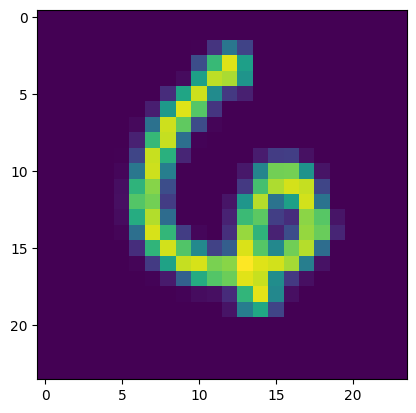

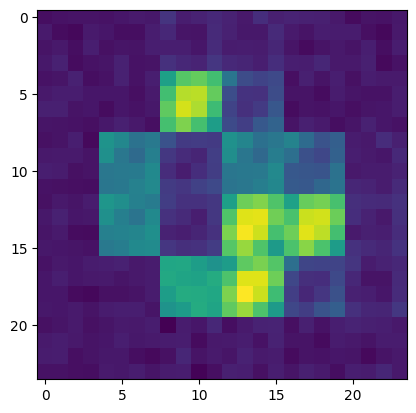

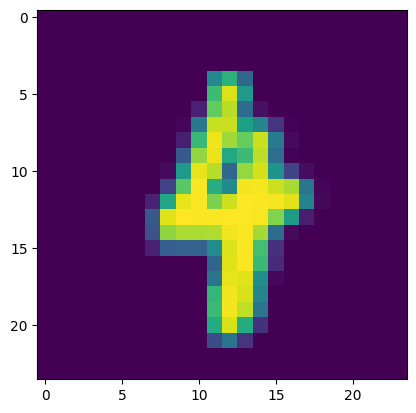

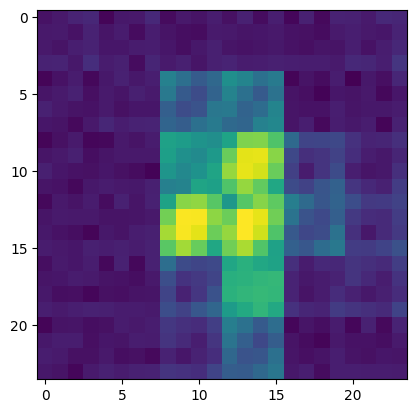

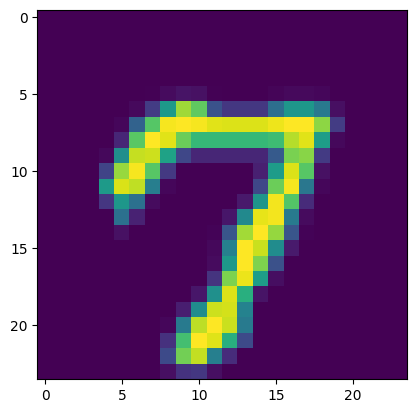

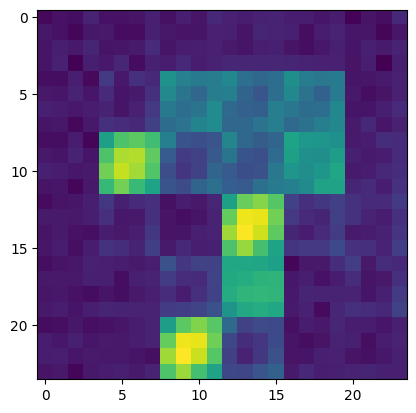

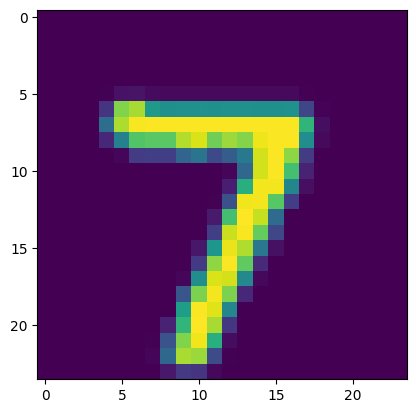

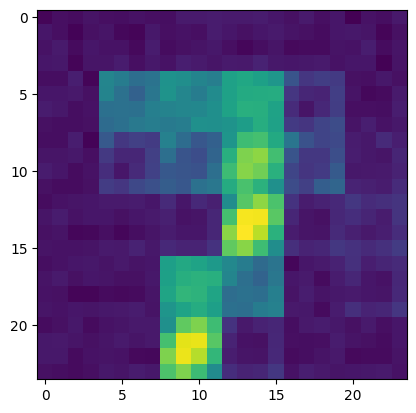

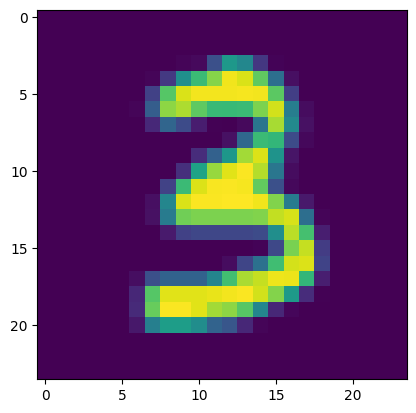

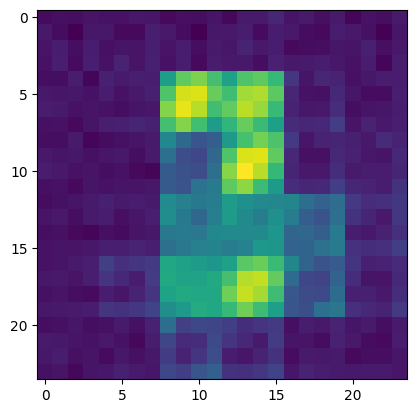

In [71]:
import matplotlib.pyplot as plt

for i in range(32):

    org = restore_tensor(batches[-2].node_features, 32, 1, 24, 24, 4)
    pred = restore_tensor(b[0].node_features, 32, 1, 24, 24, 4)

    plt.imshow(org[i].reshape(24, 24, 1).detach().numpy())
    plt.show()

    plt.imshow(pred[i].reshape(24, 24, 1).detach().numpy())
    plt.show()